# Classification with imbalanced class distributions is a major problem in machine learning. Researchers have given considerable attention to the applications in many real-world scenarios. Although several works have utilized the area under the receiver operating characteristic (ROC) curve to select potentially optimal classifiers in imbalanced classifications, limited studies have been devoted to finding the classification threshold for testing or unknown datasets. In general, the classification threshold is simply set to 0.5, which is usually unsuitable for an imbalanced classification. Here I showed, thresholds based on FPR-TPR, Precision-Recall-F1score, and Youden J-index in Python

## Loading Libraries

In [4]:
# Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interp
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from xgboost import XGBClassifier
import itertools
import glmnet
import xgboost as xgb

import seaborn as sns
sns.set_style("ticks")
mpl.rcParams['axes.linewidth'] = 3 
mpl.rcParams['lines.linewidth'] = 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline


# Functions

In [38]:
#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: _model

def _clf_train(X_train, y_train, X_test, y_test,
                 learning_rate = 0.05,
                 n_estimators = 100,
                 max_depth = 3,
                 min_child_weight = 5.0,
                 gamma = 1,
                 reg_alpha = 0.0,
                 reg_lambda = 1.0,
                 subsample = 0.9,
                 colsample_bytree = 0.9,
                 objective = "binary:logistic",
                 nthread = 4,
                 scale_pos_weight = 1.0,
                 seed = 1367,
                 random_state = 1367):
    """
    an xgboost model for training
    """

    clf = XGBClassifier(learning_rate = learning_rate,
                        n_estimators = n_estimators,
                        max_depth = max_depth,
                        min_child_weight = min_child_weight,
                        gamma = gamma,
                        reg_alpha = reg_alpha,
                        reg_lambda = reg_lambda,
                        subsample = subsample,
                        colsample_bytree = colsample_bytree,
                        objective = objective,
                        nthread = nthread,
                        scale_pos_weight = scale_pos_weight,
                        seed = seed,
                        random_state = random_state)
    
    clf.fit(X_train, y_train, eval_metric = "auc", early_stopping_rounds = 20, verbose = True, eval_set = [(X_test, y_test)])

    return clf

#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: Finding thresholds
def _threshold_finder(model, X, y_true):
    """
    a function to find the optimal threshold for binary classification
    model: a trained model object (such as xgboost, glmnet, ...)
    X: the test set of features (pandas dataframe or numpy array)
    y_true: the true class labels (list or array of 0's and 1's)    
    """
    
    y_predict_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)
    auc = roc_auc_score(y_true, y_predict_proba)
    precision, recall, thresholds2 = precision_recall_curve(y_true, y_predict_proba)
    
    class_names = [0, 1]
    youden_idx = np.argmax(np.abs(tpr - fpr))
    youden_threshold = thresholds[youden_idx]
    y_pred_youden = (y_predict_proba > youden_threshold).astype(int)
    cnf_matrix = confusion_matrix(y_true, y_pred_youden)
    np.set_printoptions(precision=2)
    
    f1 = []
    for i in range(len(precision)):
        f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))
        
    queue_rate = []
    for thr in thresholds2:
        queue_rate.append((y_predict_proba >= thr).mean()) 

    plt.figure(figsize = (10, 5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.3f}")
    plt.plot(fpr[youden_idx], tpr[youden_idx], marker = "o", color = "navy", ms =10, label =F"Youden Threshold = {youden_threshold:.2f}" )
    plt.axvline(x = fpr[youden_idx], ymin = fpr[youden_idx], ymax = tpr[youden_idx], color = "navy", ls = "--")
    plt.plot([0,1], [0,1] , color = "black", ls = "--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('1 - Specificity' , fontsize=12)
    plt.ylabel('Sensitivity' , fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend( prop={'size':12} , loc = 4)

    plt.subplot(1,2,2)
    _plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, cmap=plt.cm.Reds, title = F"Youden Threshold = {youden_threshold:.2f}\nAccuracy = {accuracy_score(y_true, y_pred_youden)*100:.2f}%")
    plt.show()
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1,2,1)
    plt.plot(thresholds, 1-fpr, label = "1 - Specificity")
    plt.plot(thresholds, tpr, label = "Sensitivity")
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds[np.argmin(abs(tpr + fpr - 1))]+0.2])
    plt.axvline(thresholds[np.argmin(abs(tpr + fpr - 1))], color="k", ls = "--")
    plt.title(F"Threshold = {thresholds[np.argmin(abs(tpr + fpr - 1))]:.3f}", fontsize = 12)
    
    plt.subplot(1,2,2)
    plt.plot(thresholds2, precision[1:], label = "Precision")
    plt.plot(thresholds2, recall[1:], label = "Recall")
    plt.plot(thresholds2, f1[1:], label = "F1-Score")
    plt.plot(thresholds2, queue_rate, label = "Queue Rate")
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds2[np.argmin(abs(precision-recall))] + 0.2])
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.axvline(thresholds2[np.argmin(abs(precision-recall))], color="k", ls = "--")
    plt.title(label = F"Threshold = {thresholds2[np.argmin(abs(precision-recall))]:.3f}", fontsize = 12)
    plt.show()

#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: Plotting Confusion Matrix
def _plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('True Class', fontsize = 14)
    plt.xlabel('Predicted Class', fontsize = 14)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

# Device Failure Data

### First, I loaded the data into a pandas dataframe to get some idea.

In [3]:
# readin the data into a dataframe
dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
df_raw = pd.read_csv("./device_failure.csv",
                     parse_dates = ["date"],
                     date_parser = dateparser,
                     encoding = "cp1252")

In [4]:
print("Shape: {}".format(df_raw.shape))
print("Prevalence = {:.3f}%".format(df_raw["failure"].sum()/df_raw.shape[0] * 100))

Shape: (124494, 12)
Prevalence = 0.085%


In [5]:
df_raw.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


### Preprocessing and builing X, Y training/testing sets.

In [6]:
target = "failure"
to_drop = ["date", "device", "attribute8", "failure"]
y = df_raw[target].values
X = df_raw.drop(to_drop, axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle = True, random_state = 1367, stratify = y)
print(F"Train Size = {X_train.shape}")
print(F"Test Size = {X_test.shape}")

Train Size = (99595, 8)
Test Size = (24899, 8)


### Printing the first 5 rows of the sclaed features. 

In [7]:
X_train.head()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
7043,154658576,0,0,6,7,211825,0,1
115494,139749056,0,0,0,8,300480,0,0
42429,150809064,0,318,0,6,310486,0,18
35289,136377576,0,0,0,12,237584,0,0
57282,60144304,0,0,1,7,307632,0,0


### Train a model

In [8]:
model = _clf_train(X_train, y_train, X_test, y_test)

[0]	validation_0-auc:0.594635
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.594635
[2]	validation_0-auc:0.618237
[3]	validation_0-auc:0.618237
[4]	validation_0-auc:0.618271
[5]	validation_0-auc:0.618271
[6]	validation_0-auc:0.618271
[7]	validation_0-auc:0.618271
[8]	validation_0-auc:0.617054
[9]	validation_0-auc:0.617054
[10]	validation_0-auc:0.662072
[11]	validation_0-auc:0.662072
[12]	validation_0-auc:0.662072
[13]	validation_0-auc:0.685412
[14]	validation_0-auc:0.685173
[15]	validation_0-auc:0.685164
[16]	validation_0-auc:0.685183
[17]	validation_0-auc:0.772991
[18]	validation_0-auc:0.773219
[19]	validation_0-auc:0.773221
[20]	validation_0-auc:0.773208
[21]	validation_0-auc:0.773261
[22]	validation_0-auc:0.773641
[23]	validation_0-auc:0.773637
[24]	validation_0-auc:0.773637
[25]	validation_0-auc:0.773635
[26]	validation_0-auc:0.773796
[27]	validation_0-auc:0.774048
[28]	validation_0-auc:0.773964
[29]	validation_0-auc:0.773948
[30]	validation_

### Visualization of Thresholds

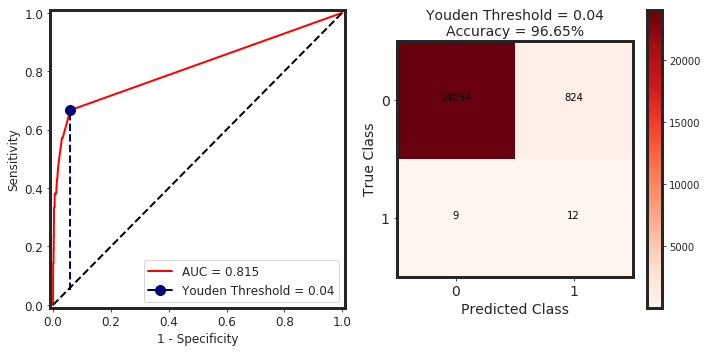

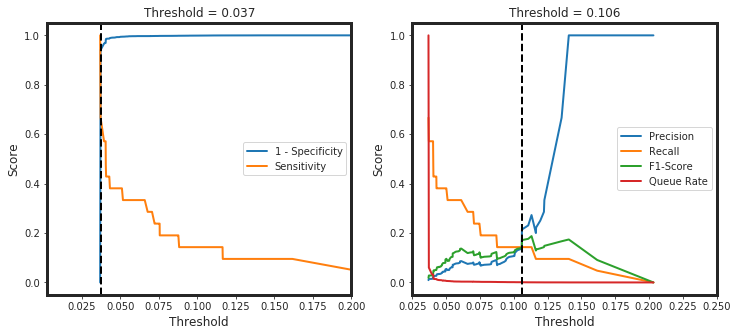

In [9]:
_threshold_finder(model = model, X = X_test, y_true = y_test)

# MNIST DATA

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version = 1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

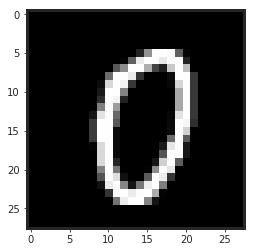

In [7]:
plt.figure()
plt.imshow(X[1000].reshape(28, 28), cmap = "gray")
plt.show()

### As you know, minist contains 10 classes. So, we need to turn this multi-class data to a binary class.

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [22]:
y_train_0 = np.where(y_train == "0", 1, 0)
y_test_0 = np.where(y_test == "0", 1, 0)

In [26]:
model = _clf_train(X_train, y_train_0, X_test, y_test_0)

[0]	validation_0-auc:0.973597
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.97854
[2]	validation_0-auc:0.985121
[3]	validation_0-auc:0.984864
[4]	validation_0-auc:0.984705
[5]	validation_0-auc:0.986008
[6]	validation_0-auc:0.987206
[7]	validation_0-auc:0.988978
[8]	validation_0-auc:0.989422
[9]	validation_0-auc:0.989856
[10]	validation_0-auc:0.990381
[11]	validation_0-auc:0.990555
[12]	validation_0-auc:0.991208
[13]	validation_0-auc:0.991901
[14]	validation_0-auc:0.992248
[15]	validation_0-auc:0.993116
[16]	validation_0-auc:0.993295
[17]	validation_0-auc:0.99356
[18]	validation_0-auc:0.994208
[19]	validation_0-auc:0.994625
[20]	validation_0-auc:0.994797
[21]	validation_0-auc:0.994938
[22]	validation_0-auc:0.994881
[23]	validation_0-auc:0.995083
[24]	validation_0-auc:0.995208
[25]	validation_0-auc:0.995286
[26]	validation_0-auc:0.995402
[27]	validation_0-auc:0.995571
[28]	validation_0-auc:0.995561
[29]	validation_0-auc:0.995693
[30]	validation_0-

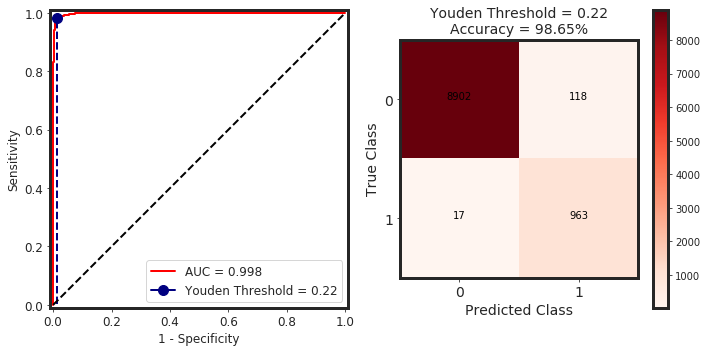

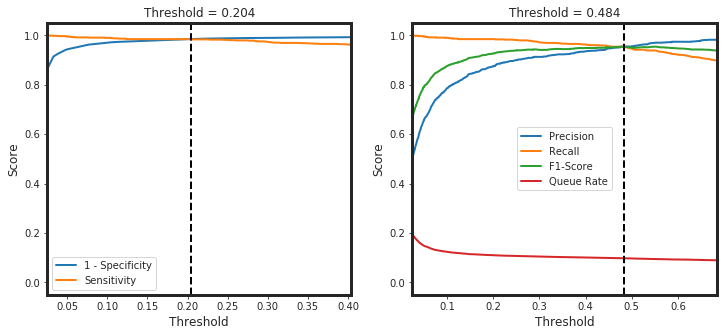

In [39]:
_threshold_finder(model = model, X = X_test, y_true = y_test_0)